In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import nltk
#nltk.download()
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.stem import PorterStemmer

from spell_corrector import rectify

import xgboost as xgb

from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

from joblib import dump, load

In [2]:
text =word_tokenize("Just Awesome. I love this Album")

nltk.pos_tag(text)

[('Just', 'RB'),
 ('Awesome', 'NNP'),
 ('.', '.'),
 ('I', 'PRP'),
 ('love', 'VBP'),
 ('this', 'DT'),
 ('Album', 'NN')]

In [3]:
text =word_tokenize("")

nltk.pos_tag(text)

[]

In [4]:
data = pd.read_csv('sample30.csv')
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [6]:
data = data[['reviews_title', 'reviews_text', 'user_sentiment', 'name']]

In [7]:
data['reviews_title'] = data['reviews_title'].str.lower()
data['reviews_text'] = data['reviews_text'].str.lower()
data

,reviews_title,reviews_text,user_sentiment,name
0,just awesome,i love this album. it's very good. more to the...,Positive,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,good,good flavor. this review was collected as part...,Positive,Lundberg Organic Cinnamon Toast Rice Cakes
2,good,good flavor.,Positive,Lundberg Organic Cinnamon Toast Rice Cakes
3,disappointed,i read through the reviews on here before look...,Negative,K-Y Love Sensuality Pleasure Gel
4,irritation,my husband bought this gel for us. the gel cau...,Negative,K-Y Love Sensuality Pleasure Gel
...,...,...,...,...
29995,softness!!,i got this conditioner with influenster to try...,Positive,L'or233al Paris Elvive Extraordinary Clay Reba...
29996,i love it,"i love it , i received this for review purpose...",Positive,L'or233al Paris Elvive Extraordinary Clay Reba...
29997,hair is so smooth after use,first of all i love the smell of this product....,Positive,L'or233al Paris Elvive Extraordinary Clay Reba...
29998,perfect for my oily hair!,i received this through influenster and will n...,Positive,L'or233al Paris Elvive Extraordinary Clay Reba...


In [8]:
data['reviews_title'] = data['reviews_title'].fillna(' ')

In [9]:
data['review'] = data[['reviews_title', 'reviews_text']].agg('. '.join, axis=1)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviews_title   30000 non-null  object
 1   reviews_text    30000 non-null  object
 2   user_sentiment  29999 non-null  object
 3   name            30000 non-null  object
 4   review          30000 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


In [11]:
data_P_R = data[['name', 'reviews_text']]

# filtering noun words from corpus

filtered_Cspell_words = []
for i in range(data_P_R.shape[0]):
    tagged = nltk.pos_tag(word_tokenize(data_P_R.reviews_text[i]))
    filtered_Cspell_words.append(' '.join([rectify(word_tag[0]) for word_tag in tagged if (word_tag[1]!='.') and (word_tag[1]!='DT') and (word_tag[1]!='CD')]))
    
data_P_R['reviews_text'] = filtered_Cspell_words

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [12]:
data = data.dropna(axis=0, subset=['user_sentiment'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviews_title   29999 non-null  object
 1   reviews_text    29999 non-null  object
 2   user_sentiment  29999 non-null  object
 3   name            29999 non-null  object
 4   review          29999 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [13]:
data = data.drop_duplicates(subset='reviews_text').reset_index(drop=True)
data.shape

(27258, 5)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27258 entries, 0 to 27257
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviews_title   27258 non-null  object
 1   reviews_text    27258 non-null  object
 2   user_sentiment  27258 non-null  object
 3   name            27258 non-null  object
 4   review          27258 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


In [15]:
data.head()

,reviews_title,reviews_text,user_sentiment,name,review
0,just awesome,i love this album. it's very good. more to the...,Positive,Pink Friday: Roman Reloaded Re-Up (w/dvd),just awesome. i love this album. it's very goo...
1,good,good flavor. this review was collected as part...,Positive,Lundberg Organic Cinnamon Toast Rice Cakes,good. good flavor. this review was collected a...
2,good,good flavor.,Positive,Lundberg Organic Cinnamon Toast Rice Cakes,good. good flavor.
3,disappointed,i read through the reviews on here before look...,Negative,K-Y Love Sensuality Pleasure Gel,disappointed. i read through the reviews on he...
4,irritation,my husband bought this gel for us. the gel cau...,Negative,K-Y Love Sensuality Pleasure Gel,irritation. my husband bought this gel for us....


#### Spell Correction & POS based Filtering

In [16]:
# filtering noun words from corpus

filtered_Cspell_words = []
for i in range(data.shape[0]):
#     tagged = nltk.pos_tag(word_tokenize(data.reviews_text[i]), tagset='universal')
#     filtered_Cspell_words.append(' '.join([rectify(word_tag[0]) for word_tag in tagged if (word_tag[1]!='NUM') and (word_tag[1]!='X')]))
    tagged = nltk.pos_tag(word_tokenize(data.reviews_text[i]))
    filtered_Cspell_words.append(' '.join([rectify(word_tag[0]) for word_tag in tagged if (word_tag[1]!='.') and (word_tag[1]!='DT') and (word_tag[1]!='CD')]))

In [17]:
data['filtered_Cspell_words'] = filtered_Cspell_words
data.head()

,reviews_title,reviews_text,user_sentiment,name,review,filtered_Cspell_words
0,just awesome,i love this album. it's very good. more to the...,Positive,Pink Friday: Roman Reloaded Re-Up (w/dvd),just awesome. i love this album. it's very goo...,i love album it is very good more to hip hop s...
1,good,good flavor. this review was collected as part...,Positive,Lundberg Organic Cinnamon Toast Rice Cakes,good. good flavor. this review was collected a...,good flavor review was collected as part of pr...
2,good,good flavor.,Positive,Lundberg Organic Cinnamon Toast Rice Cakes,good. good flavor.,good flavor
3,disappointed,i read through the reviews on here before look...,Negative,K-Y Love Sensuality Pleasure Gel,disappointed. i read through the reviews on he...,i read through reviews on here before looking ...
4,irritation,my husband bought this gel for us. the gel cau...,Negative,K-Y Love Sensuality Pleasure Gel,irritation. my husband bought this gel for us....,my husband bought get for us get caused irrita...


In [18]:
# Complete null after filtering

data[data['filtered_Cspell_words'] == '']


,reviews_title,reviews_text,user_sentiment,name,review,filtered_Cspell_words


In [19]:
data

,reviews_title,reviews_text,user_sentiment,name,review,filtered_Cspell_words
0,just awesome,i love this album. it's very good. more to the...,Positive,Pink Friday: Roman Reloaded Re-Up (w/dvd),just awesome. i love this album. it's very goo...,i love album it is very good more to hip hop s...
1,good,good flavor. this review was collected as part...,Positive,Lundberg Organic Cinnamon Toast Rice Cakes,good. good flavor. this review was collected a...,good flavor review was collected as part of pr...
2,good,good flavor.,Positive,Lundberg Organic Cinnamon Toast Rice Cakes,good. good flavor.,good flavor
3,disappointed,i read through the reviews on here before look...,Negative,K-Y Love Sensuality Pleasure Gel,disappointed. i read through the reviews on he...,i read through reviews on here before looking ...
4,irritation,my husband bought this gel for us. the gel cau...,Negative,K-Y Love Sensuality Pleasure Gel,irritation. my husband bought this gel for us....,my husband bought get for us get caused irrita...
...,...,...,...,...,...,...
27253,softness!!,i got this conditioner with influenster to try...,Positive,L'or233al Paris Elvive Extraordinary Clay Reba...,softness!!. i got this conditioner with influe...,i got conditioned with influenster to try it a...
27254,i love it,"i love it , i received this for review purpose...",Positive,L'or233al Paris Elvive Extraordinary Clay Reba...,"i love it. i love it , i received this for rev...",i love it a i received for review purposes fro...
27255,hair is so smooth after use,first of all i love the smell of this product....,Positive,L'or233al Paris Elvive Extraordinary Clay Reba...,hair is so smooth after use. first of all i lo...,first of i love smell of product after you was...
27256,perfect for my oily hair!,i received this through influenster and will n...,Positive,L'or233al Paris Elvive Extraordinary Clay Reba...,perfect for my oily hair!. i received this thr...,i received through influenster and will never ...


#### Stemming

In [20]:
# ps = PorterStemmer()

In [21]:
# filtering noun words from corpus

# stemmed_words = []
# for i in range(data.shape[0]):
#     w_list = word_tokenize(data.filtered_Cspell_words[i])
#     stemmed_words.append(' '.join([ps.stem(word) for word in w_list]))

In [22]:
# data['stemmed_words'] = stemmed_words
# data.head()

In [23]:
# Complete null after filtering

# data[data['stemmed_words'] == '']


# Model 
### TF-IDF

In [24]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        min_df=50,
                        stop_words = 'english',
                        max_features = 500,
                        ngram_range = (1,2))
feat = tfidf.fit_transform(data.filtered_Cspell_words)


In [65]:
feat

<27258x500 sparse matrix of type '<class 'numpy.float64'>'
	with 283903 stored elements in Compressed Sparse Row format>

In [25]:
X1 = pd.DataFrame(feat.toarray(), columns = tfidf.get_feature_names())
X1.head()

,able,absolutely,absolutely love,acting,action,actors,actually,add,age,ago,amazing,apply,area,areas,away,awesome,baby,bad,bag,bands,bathroom,bathroom kitchen,beautiful,bees,believe,best,best buy,better,big,bit,black,blu,blu ray,blue,blue ray,body,bottle,bought,box,boys,brand,breach,bring,brown,buy,buying,ca,came,canister,car,care,carry,cast,chair,change,changed,characters,child,children,chips,classic,classroom,clay,clean,clean disinfect,clean review,cleaner,cleaning,clear,clorox,clorox disinfecting,clorox products,clorox wiped,cocoa,cold,collected,collected promotion,collection,color,colors,come,comedy,comes,comfortable,complimentary,conditioned,container,continue,convenience,convenient,counter,counters,couple,cream,cut,daily,dark,daughter,day,days,deal,deep,definitely,desk,did,difference,different,digital,disappointed,disinfect,disinfected,disinfecting,disinfecting wiped,disney,does,door,dry,easier,easily,easy,easy clean,easy use,eat,effective,effects,end,ends,enjoy,enjoyed,entertaining,entire,especially,everyday,evil,excellent,expected,extra,extremely,face,fact,family,fan,fantastic,far,fast,favorite,feel,feel like,feeling,feels,felt,film,finally,fine,finish,flavor,floor,fly,formula,fragrance,free,fresh,friends,fun,funny,funny movie,germ,germs,gets,getting,gives,glad,glass,glided,godzilla,godzilla moves,godzilla movie,goes,going,good,good movie,good product,got,grab,greasy,great,great cleaning,great job,great movie,great price,great product,great review,hair,hand,hands,handy,happy,hard,having,healthy,heavy,help,helps,high,highly,highly recommend,hold,home,hooker,hope,hours,house,household,huge,husband,index,influenster,instead,item,job,just,keeping,keeps,kept,kind,kiss,kitchen,kitchen bathroom,know,laundry,lay,leave,leaves,left,lemon,let,life,light,like,liked,line,lip,lip swimmer,lips,lipstick,little,live,long,long time,longer,look,looked,looking,looks,lot,lotion,lots,love,love clorox,love love,love movie,love product,love smell,love use,love using,love wiped,loved,loved movie,loves,low,make,makes,making,mask,masses,mess,minutes,mon,money,monster,monsters,months,moves,movie,movie good,movie great,movie watch,natural,need,needed,needs,new,new formula,nexus,nice,night,noticed,office,oil,oily,ok,old,old formula,older,ones,online,opinions,order,original,overall,paper,past,people,perfect,pick,picture,pills,place,planes,plot,plus,powder,power,pretty,price,problem,product,product easy,product free,product great,product review,product use,products,promotion,purchase,purchased,purposes,quality,quick,quick clean,quick easy,quickly,quite,ray,real,really,really good,really like,received,received product,recommend,recommend product,recommended,red,regular,resident,resident evil,results,review,review collected,reviews,rice,right,room,roots,safe,said,saw,say,scalp,scenes,scent,school,screen,season,second,seen,sequel,series,set,shade,shampoo,shampoo conditioned,shower,sick,sink,size,skin,small,smell,smell great,smelling,smells,smells great,smooth,soft,son,soon,sound,special,special effects,spray,stains,start,started,sticky,stop,store,stores,story,story line,stove,strong,stuff,super,sure,surface,surfaces,swimmer,table,takes,taste,tell,testing,testing purposes,texture,thank,thanks,thing,things,think,thought,time,times,toilet,took,tops,touch,tried,true,trust,try,trying,tube,type,upright,use,use clean,use clorox,use product,use review,use time,use wiped,used,uses,using,using clorox,using product,usually,vacuum,value,ve,ve used,version,wait,want,wanted,wash,watch,watched,watching,water,way,wear,week,weeks,went,white,wife,wipe,wiped,wiped clean,wiped convenient,wiped easy,wiped great,wiped use,wiping,wish,wo,wonderful,work,worked,works,works great,worth,wrong,year,year old,years,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [26]:
X1.shape

(27258, 500)

In [27]:
le = preprocessing.LabelEncoder()
y_array = le.fit_transform(data.user_sentiment)
y1 = pd.DataFrame(y_array, columns=['senti'])
y1.head()

,senti
0,1
1,1
2,1
3,0
4,0


In [28]:
y1.shape

(27258, 1)

In [29]:
data_final = pd.concat([X1,y1] ,axis=1)
data_final

,able,absolutely,absolutely love,acting,action,actors,actually,add,age,ago,amazing,apply,area,areas,away,awesome,baby,bad,bag,bands,bathroom,bathroom kitchen,beautiful,bees,believe,best,best buy,better,big,bit,black,blu,blu ray,blue,blue ray,body,bottle,bought,box,boys,brand,breach,bring,brown,buy,buying,ca,came,canister,car,care,carry,cast,chair,change,changed,characters,child,children,chips,classic,classroom,clay,clean,clean disinfect,clean review,cleaner,cleaning,clear,clorox,clorox disinfecting,clorox products,clorox wiped,cocoa,cold,collected,collected promotion,collection,color,colors,come,comedy,comes,comfortable,complimentary,conditioned,container,continue,convenience,convenient,counter,counters,couple,cream,cut,daily,dark,daughter,day,days,deal,deep,definitely,desk,did,difference,different,digital,disappointed,disinfect,disinfected,disinfecting,disinfecting wiped,disney,does,door,dry,easier,easily,easy,easy clean,easy use,eat,effective,effects,end,ends,enjoy,enjoyed,entertaining,entire,especially,everyday,evil,excellent,expected,extra,extremely,face,fact,family,fan,fantastic,far,fast,favorite,feel,feel like,feeling,feels,felt,film,finally,fine,finish,flavor,floor,fly,formula,fragrance,free,fresh,friends,fun,funny,funny movie,germ,germs,gets,getting,gives,glad,glass,glided,godzilla,godzilla moves,godzilla movie,goes,going,good,good movie,good product,got,grab,greasy,great,great cleaning,great job,great movie,great price,great product,great review,hair,hand,hands,handy,happy,hard,having,healthy,heavy,help,helps,high,highly,highly recommend,hold,home,hooker,hope,hours,house,household,huge,husband,index,influenster,instead,item,job,just,keeping,keeps,kept,kind,kiss,kitchen,kitchen bathroom,know,laundry,lay,leave,leaves,left,lemon,let,life,light,like,liked,line,lip,lip swimmer,lips,lipstick,little,live,long,long time,longer,look,looked,looking,looks,lot,lotion,lots,love,love clorox,love love,love movie,love product,love smell,love use,love using,love wiped,loved,loved movie,loves,low,make,makes,making,mask,masses,mess,minutes,mon,money,monster,monsters,months,moves,movie,movie good,movie great,movie watch,natural,need,needed,needs,new,new formula,nexus,nice,night,noticed,office,oil,oily,ok,old,old formula,older,ones,online,opinions,order,original,overall,paper,past,people,perfect,pick,picture,pills,place,planes,plot,plus,powder,power,pretty,price,problem,product,product easy,product free,product great,product review,product use,products,promotion,purchase,purchased,purposes,quality,quick,quick clean,quick easy,quickly,quite,ray,real,really,really good,really like,received,received product,recommend,recommend product,recommended,red,regular,resident,resident evil,results,review,review collected,reviews,rice,right,room,roots,safe,said,saw,say,scalp,scenes,scent,school,screen,season,second,seen,sequel,series,set,shade,shampoo,shampoo conditioned,shower,sick,sink,size,skin,small,smell,smell great,smelling,smells,smells great,smooth,soft,son,soon,sound,special,special effects,spray,stains,start,started,sticky,stop,store,stores,story,story line,stove,strong,stuff,super,sure,surface,surfaces,swimmer,table,takes,taste,tell,testing,testing purposes,texture,thank,thanks,thing,things,think,thought,time,times,toilet,took,tops,touch,tried,true,trust,try,trying,tube,type,upright,use,use clean,use clorox,use product,use review,use time,use wiped,used,uses,using,using clorox,using product,usually,vacuum,value,ve,ve used,version,wait,want,wanted,wash,watch,watched,watching,water,way,wear,week,weeks,went,white,wife,wipe,wiped,wiped clean,wiped convenient,wiped easy,wiped great,wiped use,wiping,wish,wo,wonderful,work,worked,works,works great,worth,wrong,year,year old,years,young,senti
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [30]:
data_final = data_final.drop_duplicates(subset=X1.columns).reset_index(drop=True)
data_final.shape

(26340, 501)

In [31]:
data_final

,able,absolutely,absolutely love,acting,action,actors,actually,add,age,ago,amazing,apply,area,areas,away,awesome,baby,bad,bag,bands,bathroom,bathroom kitchen,beautiful,bees,believe,best,best buy,better,big,bit,black,blu,blu ray,blue,blue ray,body,bottle,bought,box,boys,brand,breach,bring,brown,buy,buying,ca,came,canister,car,care,carry,cast,chair,change,changed,characters,child,children,chips,classic,classroom,clay,clean,clean disinfect,clean review,cleaner,cleaning,clear,clorox,clorox disinfecting,clorox products,clorox wiped,cocoa,cold,collected,collected promotion,collection,color,colors,come,comedy,comes,comfortable,complimentary,conditioned,container,continue,convenience,convenient,counter,counters,couple,cream,cut,daily,dark,daughter,day,days,deal,deep,definitely,desk,did,difference,different,digital,disappointed,disinfect,disinfected,disinfecting,disinfecting wiped,disney,does,door,dry,easier,easily,easy,easy clean,easy use,eat,effective,effects,end,ends,enjoy,enjoyed,entertaining,entire,especially,everyday,evil,excellent,expected,extra,extremely,face,fact,family,fan,fantastic,far,fast,favorite,feel,feel like,feeling,feels,felt,film,finally,fine,finish,flavor,floor,fly,formula,fragrance,free,fresh,friends,fun,funny,funny movie,germ,germs,gets,getting,gives,glad,glass,glided,godzilla,godzilla moves,godzilla movie,goes,going,good,good movie,good product,got,grab,greasy,great,great cleaning,great job,great movie,great price,great product,great review,hair,hand,hands,handy,happy,hard,having,healthy,heavy,help,helps,high,highly,highly recommend,hold,home,hooker,hope,hours,house,household,huge,husband,index,influenster,instead,item,job,just,keeping,keeps,kept,kind,kiss,kitchen,kitchen bathroom,know,laundry,lay,leave,leaves,left,lemon,let,life,light,like,liked,line,lip,lip swimmer,lips,lipstick,little,live,long,long time,longer,look,looked,looking,looks,lot,lotion,lots,love,love clorox,love love,love movie,love product,love smell,love use,love using,love wiped,loved,loved movie,loves,low,make,makes,making,mask,masses,mess,minutes,mon,money,monster,monsters,months,moves,movie,movie good,movie great,movie watch,natural,need,needed,needs,new,new formula,nexus,nice,night,noticed,office,oil,oily,ok,old,old formula,older,ones,online,opinions,order,original,overall,paper,past,people,perfect,pick,picture,pills,place,planes,plot,plus,powder,power,pretty,price,problem,product,product easy,product free,product great,product review,product use,products,promotion,purchase,purchased,purposes,quality,quick,quick clean,quick easy,quickly,quite,ray,real,really,really good,really like,received,received product,recommend,recommend product,recommended,red,regular,resident,resident evil,results,review,review collected,reviews,rice,right,room,roots,safe,said,saw,say,scalp,scenes,scent,school,screen,season,second,seen,sequel,series,set,shade,shampoo,shampoo conditioned,shower,sick,sink,size,skin,small,smell,smell great,smelling,smells,smells great,smooth,soft,son,soon,sound,special,special effects,spray,stains,start,started,sticky,stop,store,stores,story,story line,stove,strong,stuff,super,sure,surface,surfaces,swimmer,table,takes,taste,tell,testing,testing purposes,texture,thank,thanks,thing,things,think,thought,time,times,toilet,took,tops,touch,tried,true,trust,try,trying,tube,type,upright,use,use clean,use clorox,use product,use review,use time,use wiped,used,uses,using,using clorox,using product,usually,vacuum,value,ve,ve used,version,wait,want,wanted,wash,watch,watched,watching,water,way,wear,week,weeks,went,white,wife,wipe,wiped,wiped clean,wiped convenient,wiped easy,wiped great,wiped use,wiping,wish,wo,wonderful,work,worked,works,works great,worth,wrong,year,year old,years,young,senti
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [32]:
X = data_final[X1.columns]
y = data_final[y1.columns]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 20,
                                     stratify = y)

#### Handling Class Imbalance

In [34]:
# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train1, y_train1)
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=0)
# X_train, y_train = rus.fit_resample(X_train1, y_train1)

In [35]:
X_train.head()

,able,absolutely,absolutely love,acting,action,actors,actually,add,age,ago,amazing,apply,area,areas,away,awesome,baby,bad,bag,bands,bathroom,bathroom kitchen,beautiful,bees,believe,best,best buy,better,big,bit,black,blu,blu ray,blue,blue ray,body,bottle,bought,box,boys,brand,breach,bring,brown,buy,buying,ca,came,canister,car,care,carry,cast,chair,change,changed,characters,child,children,chips,classic,classroom,clay,clean,clean disinfect,clean review,cleaner,cleaning,clear,clorox,clorox disinfecting,clorox products,clorox wiped,cocoa,cold,collected,collected promotion,collection,color,colors,come,comedy,comes,comfortable,complimentary,conditioned,container,continue,convenience,convenient,counter,counters,couple,cream,cut,daily,dark,daughter,day,days,deal,deep,definitely,desk,did,difference,different,digital,disappointed,disinfect,disinfected,disinfecting,disinfecting wiped,disney,does,door,dry,easier,easily,easy,easy clean,easy use,eat,effective,effects,end,ends,enjoy,enjoyed,entertaining,entire,especially,everyday,evil,excellent,expected,extra,extremely,face,fact,family,fan,fantastic,far,fast,favorite,feel,feel like,feeling,feels,felt,film,finally,fine,finish,flavor,floor,fly,formula,fragrance,free,fresh,friends,fun,funny,funny movie,germ,germs,gets,getting,gives,glad,glass,glided,godzilla,godzilla moves,godzilla movie,goes,going,good,good movie,good product,got,grab,greasy,great,great cleaning,great job,great movie,great price,great product,great review,hair,hand,hands,handy,happy,hard,having,healthy,heavy,help,helps,high,highly,highly recommend,hold,home,hooker,hope,hours,house,household,huge,husband,index,influenster,instead,item,job,just,keeping,keeps,kept,kind,kiss,kitchen,kitchen bathroom,know,laundry,lay,leave,leaves,left,lemon,let,life,light,like,liked,line,lip,lip swimmer,lips,lipstick,little,live,long,long time,longer,look,looked,looking,looks,lot,lotion,lots,love,love clorox,love love,love movie,love product,love smell,love use,love using,love wiped,loved,loved movie,loves,low,make,makes,making,mask,masses,mess,minutes,mon,money,monster,monsters,months,moves,movie,movie good,movie great,movie watch,natural,need,needed,needs,new,new formula,nexus,nice,night,noticed,office,oil,oily,ok,old,old formula,older,ones,online,opinions,order,original,overall,paper,past,people,perfect,pick,picture,pills,place,planes,plot,plus,powder,power,pretty,price,problem,product,product easy,product free,product great,product review,product use,products,promotion,purchase,purchased,purposes,quality,quick,quick clean,quick easy,quickly,quite,ray,real,really,really good,really like,received,received product,recommend,recommend product,recommended,red,regular,resident,resident evil,results,review,review collected,reviews,rice,right,room,roots,safe,said,saw,say,scalp,scenes,scent,school,screen,season,second,seen,sequel,series,set,shade,shampoo,shampoo conditioned,shower,sick,sink,size,skin,small,smell,smell great,smelling,smells,smells great,smooth,soft,son,soon,sound,special,special effects,spray,stains,start,started,sticky,stop,store,stores,story,story line,stove,strong,stuff,super,sure,surface,surfaces,swimmer,table,takes,taste,tell,testing,testing purposes,texture,thank,thanks,thing,things,think,thought,time,times,toilet,took,tops,touch,tried,true,trust,try,trying,tube,type,upright,use,use clean,use clorox,use product,use review,use time,use wiped,used,uses,using,using clorox,using product,usually,vacuum,value,ve,ve used,version,wait,want,wanted,wash,watch,watched,watching,water,way,wear,week,weeks,went,white,wife,wipe,wiped,wiped clean,wiped convenient,wiped easy,wiped great,wiped use,wiping,wish,wo,wonderful,work,worked,works,works great,worth,wrong,year,year old,years,young
14742,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.24632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.29423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234638,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [36]:
y_train.head()

,senti
14742,0
5729,1
167,1
1107,1
9465,1


In [37]:
X_train.shape

(18438, 500)

In [38]:
y_train.shape

(18438, 1)

# LR

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Train accuracy: 0.92
Test accuracy: 0.91
Train case:
              precision    recall  f1-score   support

           0       0.81      0.34      0.48      2001
           1       0.93      0.99      0.96     16437

    accuracy                           0.92     18438
   macro avg       0.87      0.67      0.72     18438
weighted avg       0.91      0.92      0.91     18438

Test case:
              precision    recall  f1-score   support

           0       0.74      0.28      0.41       857
           1       0.92      0.99      0.95      7045

    accuracy                           0.91      7902
   macro avg       0.83      0.64      0.68      7902
weighted avg       0.90      0.91      0.89      7902



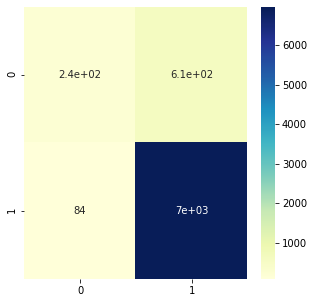

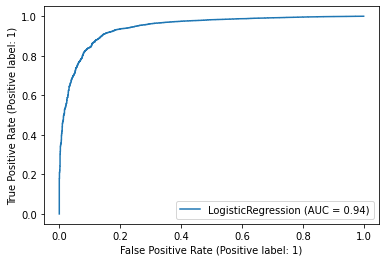

In [39]:
# Model development 

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Making prediction and evaluation

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

# Accuracy check

print('Train accuracy:', round(accuracy_score(y_train, y_train_pred),2))
print('Test accuracy:', round(accuracy_score(y_test, y_test_pred),2))

plt.subplots(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred),
           annot=True,
           cmap='YlGnBu')

print('Train case:')
print(classification_report(y_train, y_train_pred))
print('Test case:')
print(classification_report(y_test, y_test_pred))

plot_roc_curve(model_lr, X_train, y_train)

In [40]:
proba = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


train_pred = pd.DataFrame({'target':y_train.senti})
train_pred.index = y_train.index
train_pred['lr'] = model_lr.predict(X_train)
train_pred['prob_0'] = model_lr.predict_proba(X_train)[:,0]
train_pred['prob_1'] = model_lr.predict_proba(X_train)[:,1]
    
for i in proba:
    train_pred[i] = pd.DataFrame(model_lr.predict_proba(X_train)[:,1], index=X_train.index)[0].apply(lambda x: 1 if x>i else 0)
    

train_pred

,target,lr,prob_0,prob_1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
14742,0,1,0.205740,0.794260,1,1,1,1,1,1,1,0,0
5729,1,1,0.004381,0.995619,1,1,1,1,1,1,1,1,1
167,1,1,0.004148,0.995852,1,1,1,1,1,1,1,1,1
1107,1,1,0.050195,0.949805,1,1,1,1,1,1,1,1,1
9465,1,1,0.055140,0.944860,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10564,1,1,0.007971,0.992029,1,1,1,1,1,1,1,1,1
14985,1,1,0.344940,0.655060,1,1,1,1,1,1,0,0,0
11674,1,1,0.061900,0.938100,1,1,1,1,1,1,1,1,1
17044,1,1,0.047992,0.952008,1,1,1,1,1,1,1,1,1


<AxesSubplot:ylabel='Frequency'>

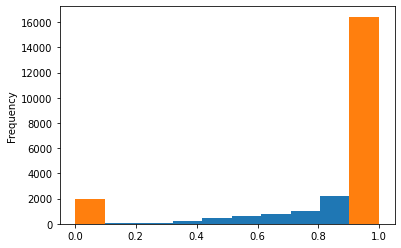

In [41]:
train_pred.prob_1.plot(kind='hist')
# train_pred.prob_1.plot(kind='hist')
train_pred.target.plot(kind='hist')

In [42]:
# Tradeoff
mat = []
for i in proba:
    cm = confusion_matrix(train_pred.target, train_pred[i])
    acc = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    sens = cm[1,1] / float(cm[1,1]+cm[1,0])
    spec = cm[0,0] / float(cm[0,0]+cm[0,1])
    prec = cm[1,1] / float(cm[1,1]+cm[0,1])
    rec = sens
    mat.append([i, acc, sens, spec, prec, rec])
    
dist = pd.DataFrame(mat, columns=['cut-off','acc', 'sens', 'spec', 'prec', 'rec'])
dist

,cut-off,acc,sens,spec,prec,rec
0,0.1,0.892993,0.999817,0.015492,0.892958,0.999817
1,0.2,0.895325,0.999392,0.040480,0.895351,0.999392
2,0.3,0.899338,0.998783,0.082459,0.899414,0.998783
3,0.4,0.907094,0.996654,0.171414,0.908093,0.996654
4,0.5,0.920273,0.990388,0.344328,0.925416,0.990388
5,0.6,0.932531,0.977794,0.560720,0.948145,0.977794
6,0.7,0.929005,0.951877,0.741129,0.967953,0.951877
7,0.8,0.901399,0.906796,0.857071,0.981173,0.906796
8,0.9,0.800900,0.785484,0.927536,0.988894,0.785484


<AxesSubplot:xlabel='cut-off'>

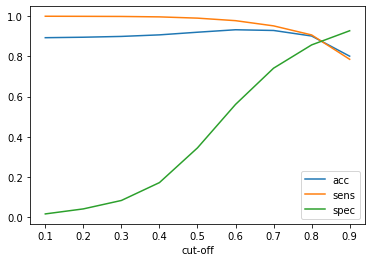

In [43]:
# Sens Vs Spec
dist.plot.line(x='cut-off', y=['acc', 'sens', 'spec'])

<AxesSubplot:xlabel='cut-off'>

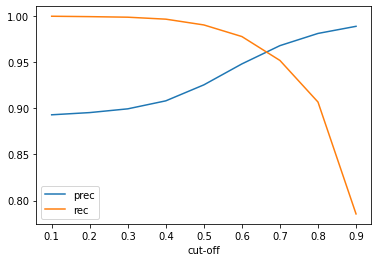

In [44]:
# Prec Vs Recall

dist.plot.line(x='cut-off', y=['prec', 'rec'])

Train accuracy: 0.93
Test accuracy: 0.92
Train case:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69      2001
           1       0.96      0.96      0.96     16437

    accuracy                           0.93     18438
   macro avg       0.82      0.83      0.83     18438
weighted avg       0.93      0.93      0.93     18438

Test case:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64       857
           1       0.96      0.95      0.96      7045

    accuracy                           0.92      7902
   macro avg       0.79      0.81      0.80      7902
weighted avg       0.92      0.92      0.92      7902



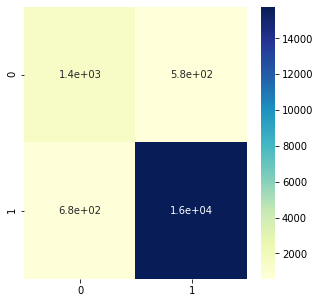

In [67]:
# updating the prediction using cut-off probability
train_pred['prediction'] = pd.DataFrame(model_lr.predict_proba(X_train)[:,1], index=X_train.index)[0].apply(lambda x: 1 if x>0.68 else 0)
train_pred

# updating the prediction using cut-off probability
test_pred = pd.DataFrame(model_lr.predict_proba(X_test)[:,1], index=X_test.index)[0].apply(lambda x: 1 if x>0.68 else 0)


# Accuracy check

print('Train accuracy:', round(accuracy_score(y_train, train_pred['prediction']),2))
print('Test accuracy:', round(accuracy_score(y_test, test_pred),2))

plt.subplots(figsize=(5,5))
sns.heatmap(confusion_matrix(y_train, train_pred['prediction']),
           annot=True,
           cmap='YlGnBu')

print('Train case:')
print(classification_report(y_train, train_pred['prediction']))
print('Test case:')
print(classification_report(y_test, test_pred))



# NB

In [46]:
# # Model development 

# model_nb = MultinomialNB()
# model_nb.fit(X_train, y_train)

# # Making prediction and evaluation

# y_train_pred = model_nb.predict(X_train)
# y_test_pred = model_nb.predict(X_test)

# # Accuracy check

# print('Train accuracy:', round(accuracy_score(y_train, y_train_pred),2))
# print('Test accuracy:', round(accuracy_score(y_test, y_test_pred),2))

# plt.subplots(figsize=(5,5))
# sns.heatmap(confusion_matrix(y_test, y_test_pred),
#            annot=True,
#            cmap='YlGnBu')

# print('Train case:')
# print(classification_report(y_train, y_train_pred))
# print('Test case:')
# print(classification_report(y_test, y_test_pred))

# plot_roc_curve(model_nb, X_train, y_train)

In [47]:
# proba = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


# train_pred = pd.DataFrame({'target':y_train.senti})
# train_pred.index = y_train.index
# train_pred['nb'] = model_nb.predict(X_train)
# train_pred['prob_0'] = model_nb.predict_proba(X_train)[:,0]
# train_pred['prob_1'] = model_nb.predict_proba(X_train)[:,1]
    
# for i in proba:
#     train_pred[i] = pd.DataFrame(model_nb.predict_proba(X_train)[:,1], index=X_train.index)[0].apply(lambda x: 1 if x>i else 0)
    

# train_pred

In [48]:
# train_pred.prob_1.plot(kind='hist')
# # train_pred.prob_1.plot(kind='hist')
# train_pred.target.plot(kind='hist')

In [49]:
# # Tradeoff
# mat = []
# for i in proba:
#     cm = confusion_matrix(train_pred.target, train_pred[i])
#     acc = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
#     sens = cm[1,1] / float(cm[1,1]+cm[1,0])
#     spec = cm[0,0] / float(cm[0,0]+cm[0,1])
#     prec = cm[1,1] / float(cm[1,1]+cm[0,1])
#     rec = sens
#     mat.append([i, acc, sens, spec, prec, rec])
    
# dist = pd.DataFrame(mat, columns=['cut-off','acc', 'sens', 'spec', 'prec', 'rec'])
# dist

In [50]:
# # Sens Vs Spec
# dist.plot.line(x='cut-off', y=['acc', 'sens', 'spec'])

In [51]:
# # Prec Vs Recall

# dist.plot.line(x='cut-off', y=['prec', 'rec'])

In [52]:
# # updating the prediction using cut-off probability
# train_pred['prediction'] = pd.DataFrame(model_nb.predict_proba(X_train)[:,1], index=X_train.index)[0].apply(lambda x: 1 if x>0.85 else 0)
# train_pred

# # updating the prediction using cut-off probability
# test_pred = pd.DataFrame(model_nb.predict_proba(X_test)[:,1], index=X_test.index)[0].apply(lambda x: 1 if x>0.85 else 0)


# # Accuracy check

# print('Train accuracy:', round(accuracy_score(y_train, train_pred['prediction']),2))
# print('Test accuracy:', round(accuracy_score(y_test, test_pred),2))

# plt.subplots(figsize=(5,5))
# sns.heatmap(confusion_matrix(y_train, train_pred['prediction']),
#            annot=True,
#            cmap='YlGnBu')

# print('Train case:')
# print(classification_report(y_train, train_pred['prediction']))
# print('Test case:')
# print(classification_report(y_test, test_pred))


# XGB

In [53]:
# model_xgb = xgb.XGBClassifier()

# model_xgb.fit(X_train, y_train)

# # Making prediction and evaluation

# y_train_pred = model_xgb.predict(X_train)
# y_test_pred = model_xgb.predict(X_test)

# # Accuracy check

# print('Train accuracy:', round(accuracy_score(y_train, y_train_pred),2))
# print('Test accuracy:', round(accuracy_score(y_test, y_test_pred),2))

# plt.subplots(figsize=(5,5))
# sns.heatmap(confusion_matrix(y_test, y_test_pred),
#            annot=True,
#            cmap='YlGnBu')

# print('Train case:')
# print(classification_report(y_train, y_train_pred))
# print('Test case:')
# print(classification_report(y_test, y_test_pred))


# plot_roc_curve(model_xgb, X_train, y_train)

In [54]:
# proba = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


# train_pred = pd.DataFrame({'target':y_train.senti})
# train_pred.index = y_train.index
# train_pred['xgb'] = model_xgb.predict(X_train)
# train_pred['prob_0'] = model_xgb.predict_proba(X_train)[:,0]
# train_pred['prob_1'] = model_xgb.predict_proba(X_train)[:,1]
    
# for i in proba:
#     train_pred[i] = pd.DataFrame(model_xgb.predict_proba(X_train)[:,1], index=X_train.index)[0].apply(lambda x: 1 if x>i else 0)
    

# train_pred

In [55]:
# train_pred.prob_1.plot(kind='hist')
# # train_pred.prob_1.plot(kind='hist')
# train_pred.target.plot(kind='hist')

In [56]:
# # Tradeoff
# mat = []
# for i in proba:
#     cm = confusion_matrix(train_pred.target, train_pred[i])
#     acc = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
#     sens = cm[1,1] / float(cm[1,1]+cm[1,0])
#     spec = cm[0,0] / float(cm[0,0]+cm[0,1])
#     prec = cm[1,1] / float(cm[1,1]+cm[0,1])
#     rec = sens
#     mat.append([i, acc, sens, spec, prec, rec])
    
# dist = pd.DataFrame(mat, columns=['cut-off','acc', 'sens', 'spec', 'prec', 'rec'])
# dist

In [57]:
# # Sens Vs Spec
# dist.plot.line(x='cut-off', y=['acc', 'sens', 'spec'])

In [58]:
# # Prec Vs Recall

# dist.plot.line(x='cut-off', y=['prec', 'rec'])

In [59]:
# # updating the prediction using cut-off probability
# train_pred['prediction'] = pd.DataFrame(model_xgb.predict_proba(X_train)[:,1], index=X_train.index)[0].apply(lambda x: 1 if x>0.75 else 0)
# train_pred

# # updating the prediction using cut-off probability
# test_pred = pd.DataFrame(model_xgb.predict_proba(X_test)[:,1], index=X_test.index)[0].apply(lambda x: 1 if x>0.75 else 0)

# # Accuracy check

# print('Train accuracy:', round(accuracy_score(y_train, train_pred['prediction']),2))
# print('Test accuracy:', round(accuracy_score(y_test, test_pred),2))

# plt.subplots(figsize=(5,5))
# sns.heatmap(confusion_matrix(y_train, train_pred['prediction']),
#            annot=True,
#            cmap='YlGnBu')

# print('Train case:')
# print(classification_report(y_train, train_pred['prediction']))
# print('Test case:')
# print(classification_report(y_test, test_pred))


# Final Model

In [60]:
# Model development 

model_senti = LogisticRegression()
model_senti.fit(X, y)

# Use probability threshold of 0.68 while deployment

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [61]:
# Saving model

dump(model_senti, open('model_senti.pkl', 'wb'))
model_senti1 = load(open('model_senti.pkl', 'rb'))
model_senti1

LogisticRegression()

In [62]:
# Saving data_P_R (product name and reveiw_text)

dump(data_P_R, open('data_P_R.pkl', 'wb'))
data_P_R1 = load(open('data_P_R.pkl', 'rb'))
data_P_R1

,name,reviews_text
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love album it is very good more to hip hop s...
1,Lundberg Organic Cinnamon Toast Rice Cakes,good flavor review was collected as part of pr...
2,Lundberg Organic Cinnamon Toast Rice Cakes,good flavor
3,K-Y Love Sensuality Pleasure Gel,i read through reviews on here before looking ...
4,K-Y Love Sensuality Pleasure Gel,my husband bought get for us get caused irrita...
...,...,...
29995,L'or233al Paris Elvive Extraordinary Clay Reba...,i got conditioned with influenster to try it a...
29996,L'or233al Paris Elvive Extraordinary Clay Reba...,i love it a i received for review purposes fro...
29997,L'or233al Paris Elvive Extraordinary Clay Reba...,first of i love smell of product after you was...
29998,L'or233al Paris Elvive Extraordinary Clay Reba...,i received through influenster and will never ...


In [63]:
# Saving tfidf vectorizer

dump(tfidf, open('tfidf.pkl', 'wb'))
tfidf1 = load(open('tfidf.pkl', 'rb'))
tfidf1

TfidfVectorizer(max_features=500, min_df=50, ngram_range=(1, 2),
                stop_words='english', sublinear_tf=True)

In [3]:
user_final_rating = load(open('user_final_rating.pkl', 'rb'))

        # loading sentiment analysis model
model_senti = load(open('model_senti.pkl', 'rb'))

        # loading Product Name Vs Reveiw_text table
data_P_R = load(open('data_P_R.pkl', 'rb'))

        # loading TFIDF vectorizer
tfidf = load(open('tfidf.pkl', 'rb'))

user_name = '00sab00'

In [4]:
d = user_final_rating.loc[user_name].sort_values(ascending=False)[0:20]
product_list = d.index.to_list()

tfidf_input = data_P_R[data_P_R.name.isin(product_list)].reset_index(drop=True)
feat = tfidf.transform(tfidf_input['reviews_text'])
X = pd.DataFrame(feat.toarray(), columns = tfidf.get_feature_names())

In [5]:
preds = pd.DataFrame(model_senti.predict_proba(X)[:,1], index=X.index)[0].apply(lambda x: 1 if x>0.68 else 0)
tfidf_input['predictions'] = preds

In [6]:
tfidf_input.head()

,name,reviews_text,predictions
0,Windex Original Glass Cleaner Refill 67.6oz (2...,leaves windows with streaks a although it does...,1
1,Windex Original Glass Cleaner Refill 67.6oz (2...,it leaves streaks bad i used windsheild washed...,1
2,Windex Original Glass Cleaner Refill 67.6oz (2...,very disappointed in product it leaves kinds o...,0
3,Windex Original Glass Cleaner Refill 67.6oz (2...,index used to be good years ago since they ref...,1
4,Windex Original Glass Cleaner Refill 67.6oz (2...,having used index for years a i noticed in las...,1


In [1]:
from flask import Flask, render_template, request
import pandas as pd
import numpy as np
from joblib import load

user_name = '00sab00'

        # loading user_final_rating table (from recommendation engine)
user_final_rating = load(open('user_final_rating.pkl', 'rb'))

        # loading sentiment analysis model
model_senti = load(open('model_senti.pkl', 'rb'))

        # loading Product Name Vs Reveiw_text table
data_P_R = load(open('data_P_R.pkl', 'rb'))

        # loading TFIDF vectorizer
tfidf = load(open('tfidf.pkl', 'rb'))

d = pd.DataFrame(user_final_rating.loc[user_name]).sort_values(by = user_name, ascending=False).head(20)
# d = user_final_rating.loc[user_name].sort_values(ascending=False)[0:20]
product_list = d.index.to_list()

tfidf_input = data_P_R[data_P_R.name.isin(product_list)]
feat = tfidf.transform(tfidf_input['reviews_text'])
X = pd.DataFrame(feat.toarray(), columns = tfidf.get_feature_names())

preds = pd.DataFrame(model_senti.predict_proba(X)[:,1], index=X.index)[0].apply(lambda x: 1 if x>0.68 else 0)
tfidf_input['predictions'] = preds

        #final result
fin_res = pd.DataFrame(tfidf_input.groupby('name')['predictions'].mean()).sort_values(by='predictions', ascending=False).head().index.to_list()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
fin_res

['Coty Airspun Face Powder, Translucent Extra Coverage',
 'Hormel Chili, No Beans',
 'Equals (blu-Ray)',
 'Lysol Concentrate Deodorizing Cleaner, Original Scent',
 'The Resident Evil Collection 5 Discs (blu-Ray)']

In [7]:
" ".join([user_name])

'00sab00'